In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
BASE_DIR = "../training/training_metrics"
DATASETS = ["small", "medium", "full"]

In [3]:
def load_metrics(path):
    with open(path, "rb") as f:
        return pickle.load(f)

In [4]:
all_metrics = {}
for folder in os.listdir(BASE_DIR):
    if not folder.endswith(".pkl"):
        file_path = os.path.join(BASE_DIR, folder, folder + ".pkl")
        if os.path.exists(file_path):
            all_metrics[folder] = load_metrics(file_path)

In [5]:
def plot_metric(metric_name, dataset):
    plt.figure(figsize=(10,6))
    for model_name, log in all_metrics.items():
        if f"set_{dataset}" in model_name:
            values = log["history"].get(metric_name, [])
            plt.plot(range(1, len(values)+1), values, label=model_name, linewidth=2)
    plt.title(f"{metric_name} across models ({dataset} dataset)")
    plt.xlabel("Epoch")
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [13]:
final_results = []
for model_name, log in all_metrics.items():
    history = log["history"]
    
    final_results.append({
        "model": model_name,
        "train_time_sec": sum(l["time_seconds"] for l in log["epoch_times"]), 
        "gpu_mem_avg": 1.0 * sum(l['gpu_memory_used_mb'] for l in log["gpu_memory_log"]) / len(log["gpu_memory_log"]) if log["gpu_memory_log"] else 0,
        "avg_epoch_time": sum(l["time_seconds"] for l in log["epoch_times"]) / len(log["epoch_times"]),
        "num_epochs": len(log["epoch_times"])
    })

df_results = pd.DataFrame(final_results)

In [14]:
print("\n=== GPU Usage (avg MB) ===")
print(df_results[["model", "gpu_mem_avg"]].sort_values("gpu_mem_avg"))


=== GPU Usage (avg MB) ===
                               model  gpu_mem_avg
14       head_fine_tuning_set_medium   855.000000
4          head_fine_tuning_set_full   855.000000
5         head_fine_tuning_set_small   855.000000
7      lora_r_32_alpha_64_set_medium   876.750000
12       lora_r_32_alpha_64_set_full   877.000000
11      lora_r_32_alpha_64_set_small   877.000000
8    adapters_inner_dim_48_set_small   898.500000
1   adapters_inner_dim_48_set_medium   899.000000
0      lora_r_64_alpha_32_set_medium   899.200000
16    adapters_inner_dim_96_set_full   899.333333
9   adapters_inner_dim_96_set_medium   899.500000
6        lora_r_64_alpha_32_set_full   899.500000
13    adapters_inner_dim_48_set_full   899.500000
17   adapters_inner_dim_96_set_small   899.500000
15      lora_r_64_alpha_32_set_small   900.000000
10        full_fine_tuning_set_small  2109.666667
2          full_fine_tuning_set_full  2111.000000
3        full_fine_tuning_set_medium  2122.000000


In [16]:
summary = df_results[["model", "train_time_sec", "num_epochs", "avg_epoch_time"]].copy()
summary["train_time_sec"] = summary["train_time_sec"].map("{:.2f}".format)
summary["avg_epoch_time"] = summary["avg_epoch_time"].map("{:.2f}".format)

print("\n=== Training Efficiency Summary ===")
print(summary.sort_values("model").to_string(index=False))


=== Training Efficiency Summary ===
                           model train_time_sec  num_epochs avg_epoch_time
  adapters_inner_dim_48_set_full         997.67           2         498.84
adapters_inner_dim_48_set_medium          20.49           1          20.49
 adapters_inner_dim_48_set_small           7.21           2           3.61
  adapters_inner_dim_96_set_full        1505.78           3         501.93
adapters_inner_dim_96_set_medium          41.69           2          20.84
 adapters_inner_dim_96_set_small           6.93           2           3.46
       full_fine_tuning_set_full         520.97           1         520.97
     full_fine_tuning_set_medium          43.09           2          21.54
      full_fine_tuning_set_small           8.81           3           2.94
       head_fine_tuning_set_full         761.07           4         190.27
     head_fine_tuning_set_medium          39.96           5           7.99
      head_fine_tuning_set_small           0.98           1    

In [10]:
def plot_overfitting(dataset, model_prefix):
    plt.figure(figsize=(10,6))
    for model_name, log in [metric for metric in all_metrics.items() if metric[0].startswith(model_prefix)]:
        if f"set_{dataset}" in model_name:
            train_loss = log["history"]["train_loss"]
            val_loss = log["history"]["val_loss"]
            plt.plot(range(1, len(train_loss)+1), train_loss, "--", label=f"{model_name} train")
            plt.plot(range(1, len(val_loss)+1), val_loss, label=f"{model_name} val")
    plt.title(f"Train vs Validation Loss ({dataset} dataset)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

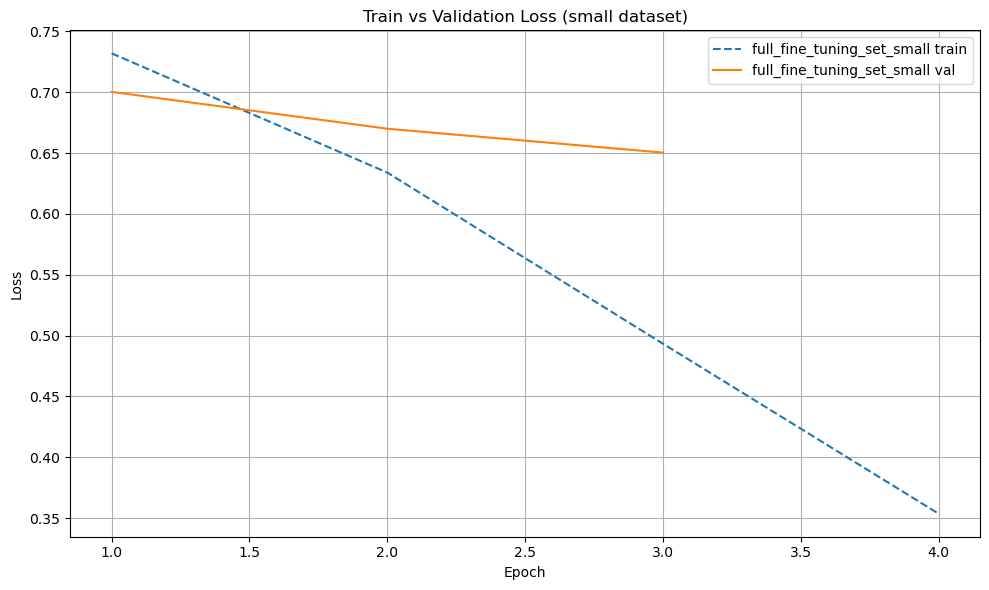

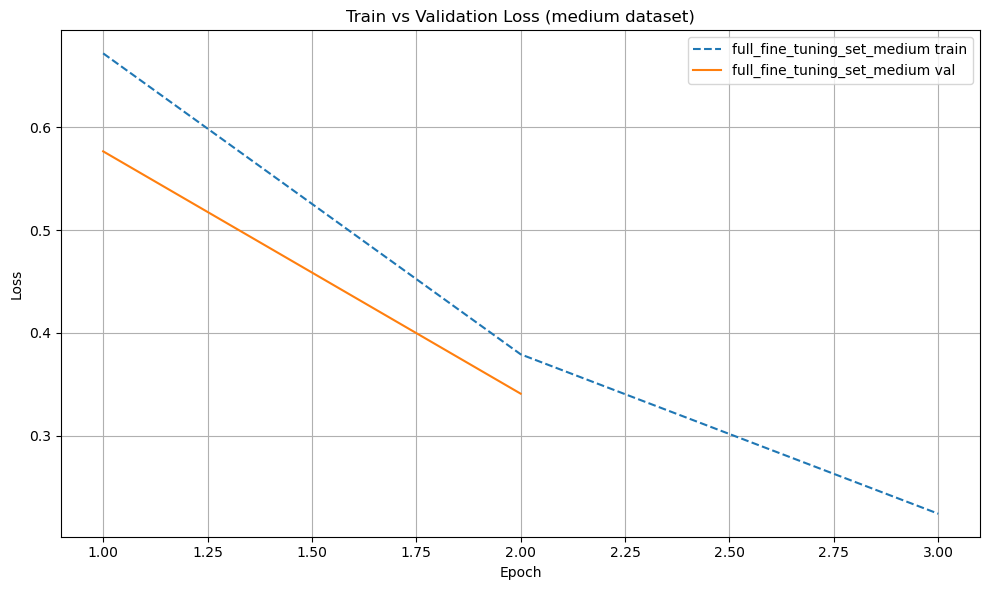

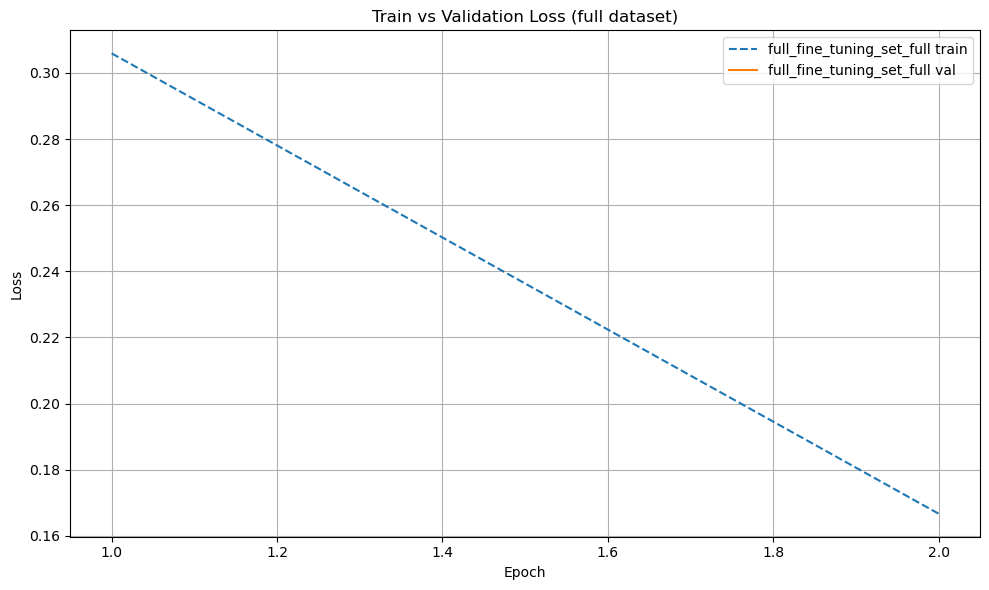

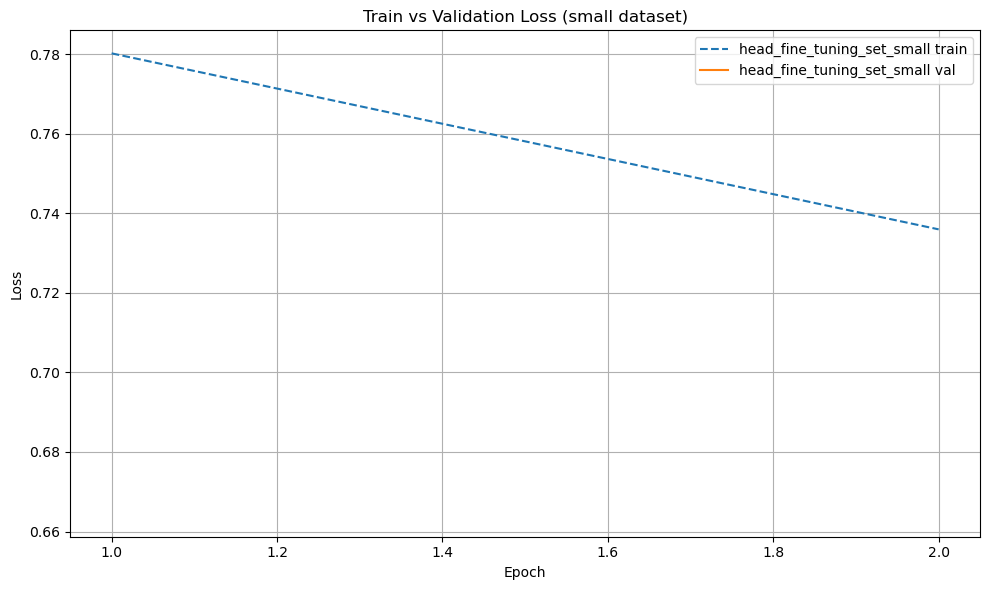

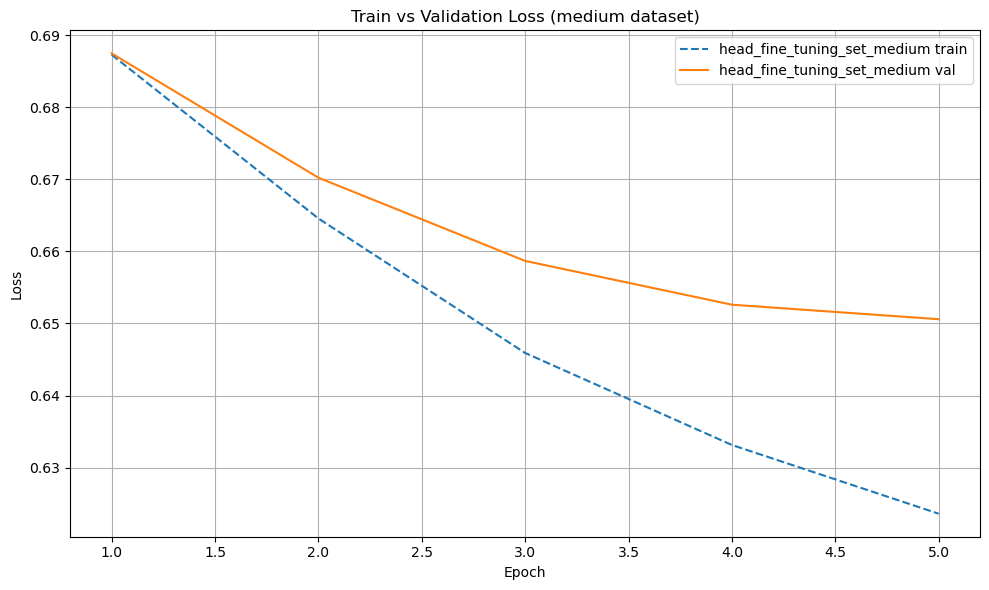

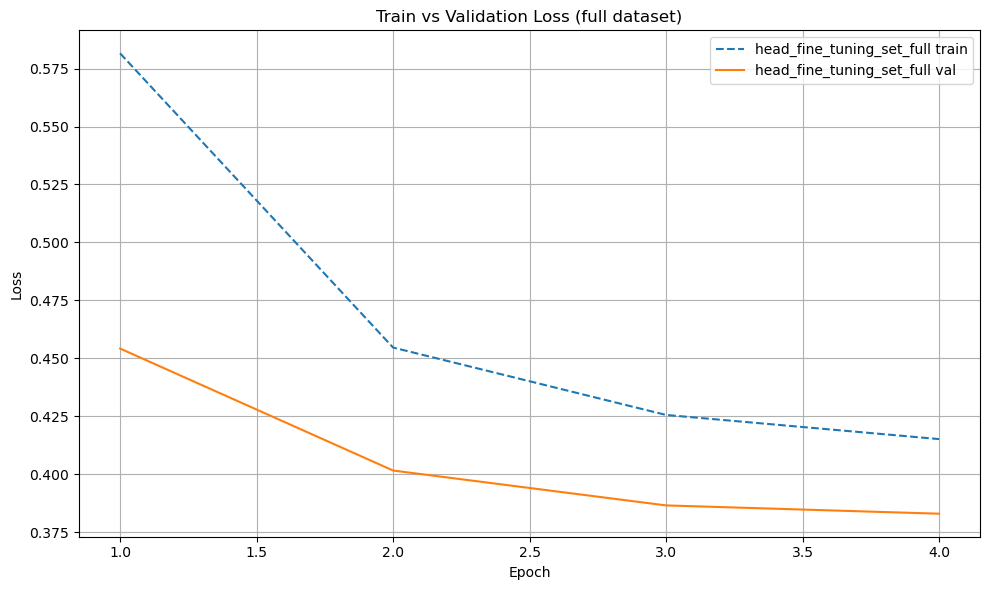

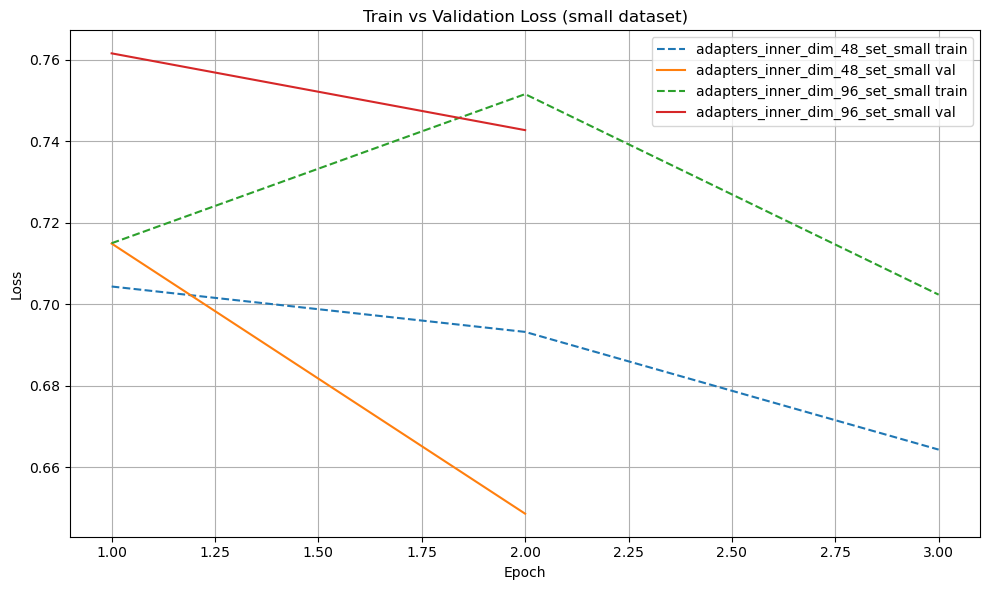

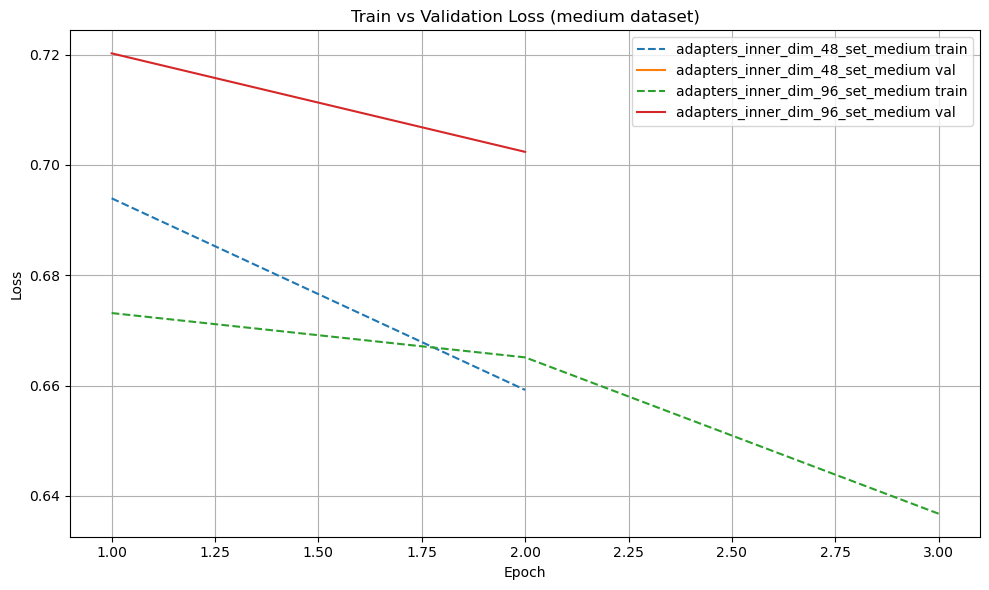

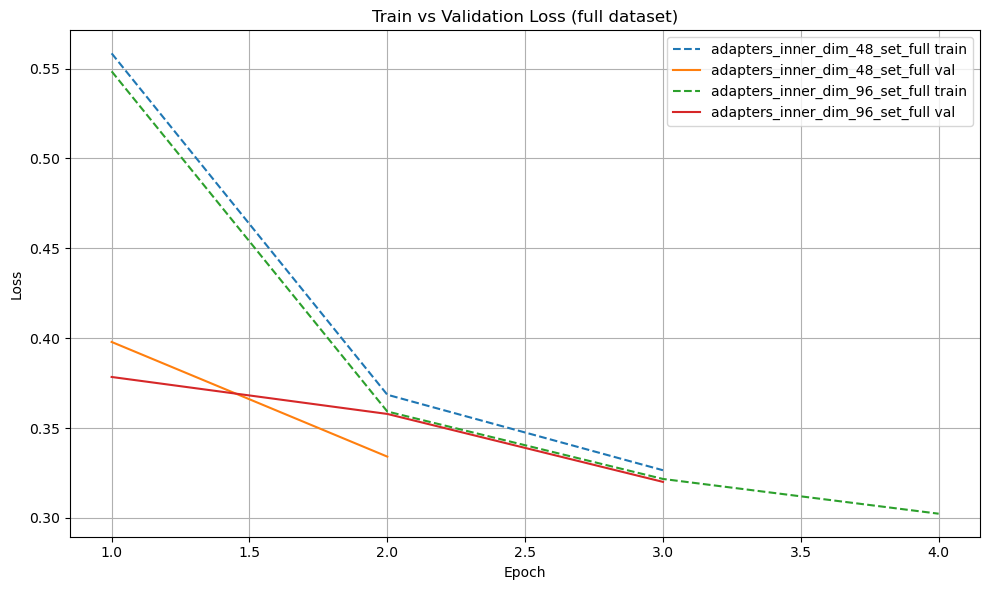

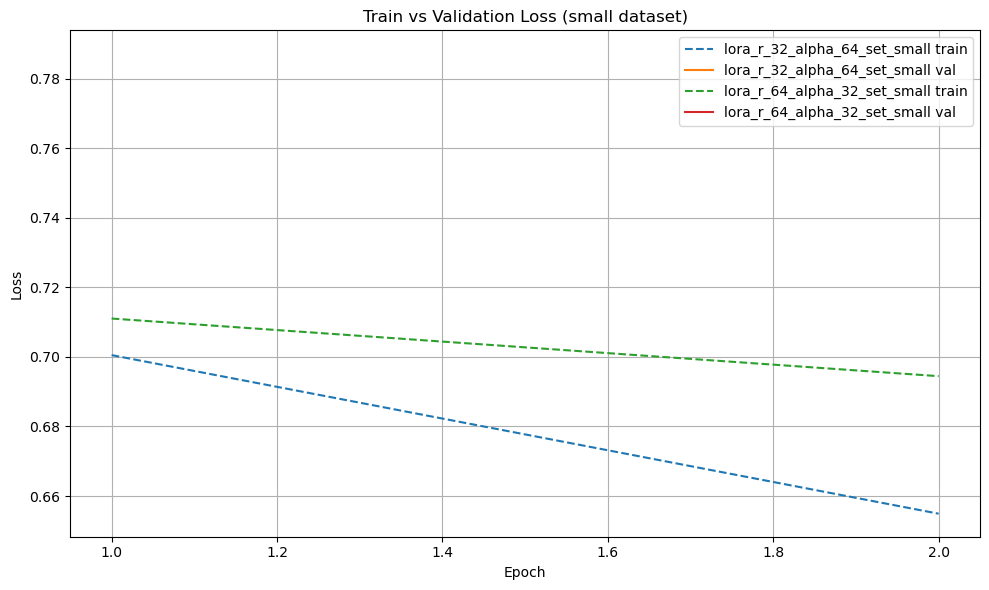

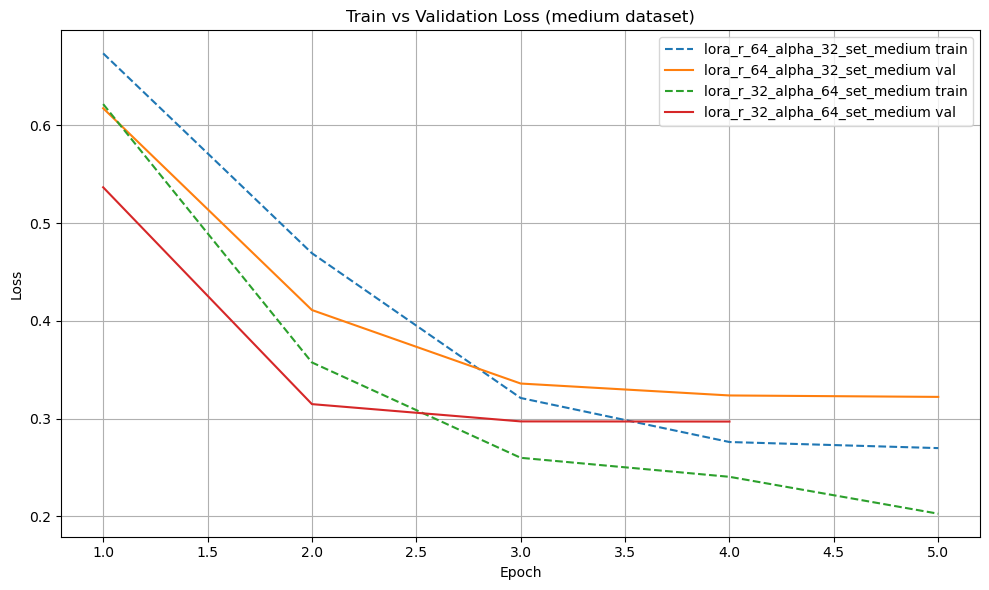

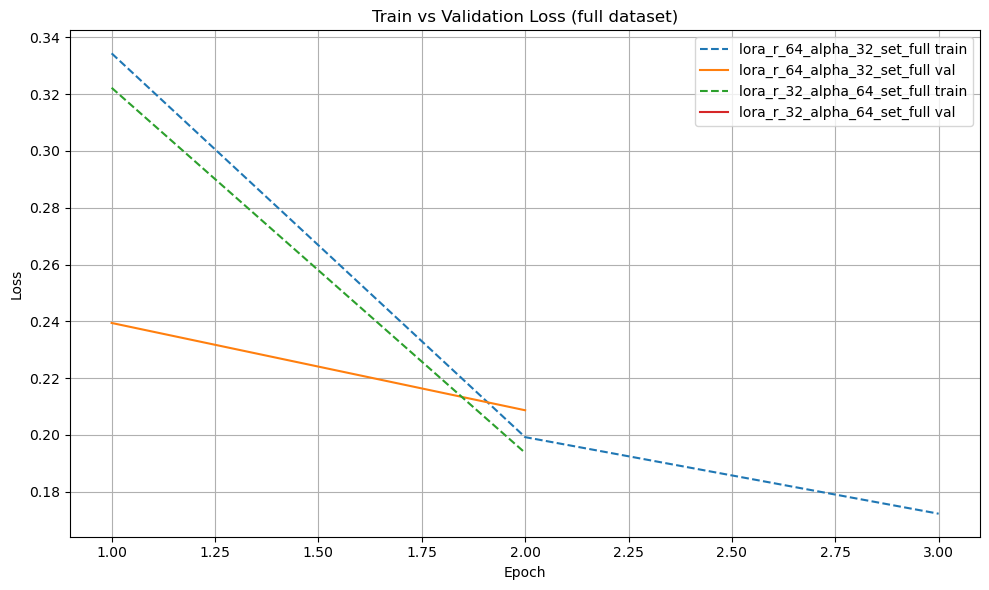

In [11]:
for model_prefix in ['full', 'head', 'adapters', 'lora']:
    for dataset in DATASETS:
        plot_overfitting(dataset, model_prefix)